# Garbage Classification using Deep Learning

### Team Members
 
- **Kshitij Yerande - 40194579**
- **Siddhartha Jha - 40201472**
- **Adwait R Sambare - 40162664**

### Problem Statement
The goal is to classify garbage images into 6 categories (cardboard, glass, metal, paper, plastic and trash) using Deep learning CNN architectures and feature based models to identify the recyclability status of garbage. We also evaluate the performance of different solution approaches.

### Dataset
The dataset is retrieved from trahsnet repository. 

Link: https://github.com/garythung/trashnet/tree/master/data

### Evaluation metrics

1. Accuracy: It is the most intuitive performance measure, and it is simply the ratio of correctly predicted observation to the total observations.
2. Precision: It is the ratio of the correctly predicted positive observations.
3. Recall: It is the ratio of correctly predicted positive observations to all observations in actual class.
4. F-score: It is the weighted average of precision and recall.

### Solution approaches

- Custom-CNN model: CNN architecture desined from scratch
- ResNet50 (Pre-trained) : Pretrained weights of ImageNet dataset used to train last layer on our dataset.
- SVM with HOG features(histogram of gradients) : HOG feature extracted and trained using SVM

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, vgg16_bn
import torchvision.transforms as transforms


from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset, WeightedRandomSampler
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torchviz import make_dot
import cv2

In [10]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/archive'
NUM_CLASSES = 6 # no of classes in the garbage dataset
BATCH_SIZE = 500 # for dataloader

cpu


### Data Preprocessing - Applying Transformations

In [11]:
# Resize images and normalize pixel values before passing it to the model
transformations = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

dataset = ImageFolder(DATASET_DIR, transform = transformations)

CLASSES = dataset.class_to_idx.keys()
TEST_CLASSES = dataset.class_to_idx.keys()
print('Total data',len(dataset))
print('Classes')
display(dataset.class_to_idx)

Total data 2644
Classes


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

### Visualizing Data

Image sampled from class 0 - "cardboard"


<Figure size 1400x700 with 0 Axes>

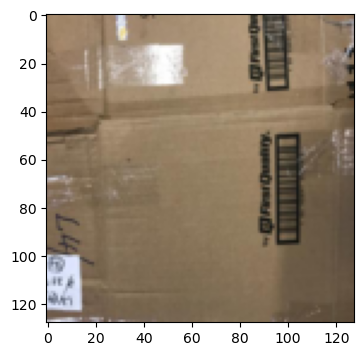

<Figure size 1400x700 with 0 Axes>

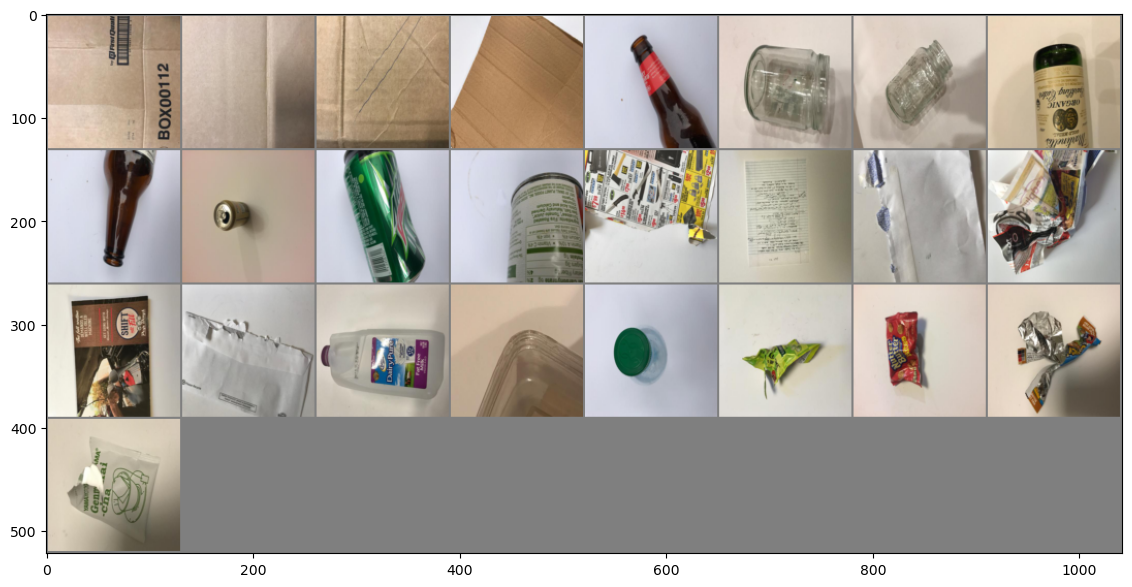

In [29]:
# utility method to print class label(s) and show image(s) of a row in the dataset
def imshow(image):
    plt.figure(figsize=(14,7))
    if not isinstance(image,torch.Tensor):
        plt.figure(figsize=(4,4))
        print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')
        npimg = np.array(image[0])
    else:
        plt.figure(figsize=(14,7))
        npimg = image.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(dataset[10])
imshow(make_grid([dataset[idx][0] for idx in range(1,len(dataset),110)]))

In [12]:
all_idxs = np.arange(len(dataset))

# perform a 70/30 train-test split
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)

# get the train and test set targets/labels
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]

# set the test set's dataloader
test_set_loader = DataLoader(Subset(dataset, test_idxs), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_sampled_dataloader = DataLoader(Subset(dataset, train_idxs), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 1850
test dataset 794


### Visualizing datadistribution - after oversampling

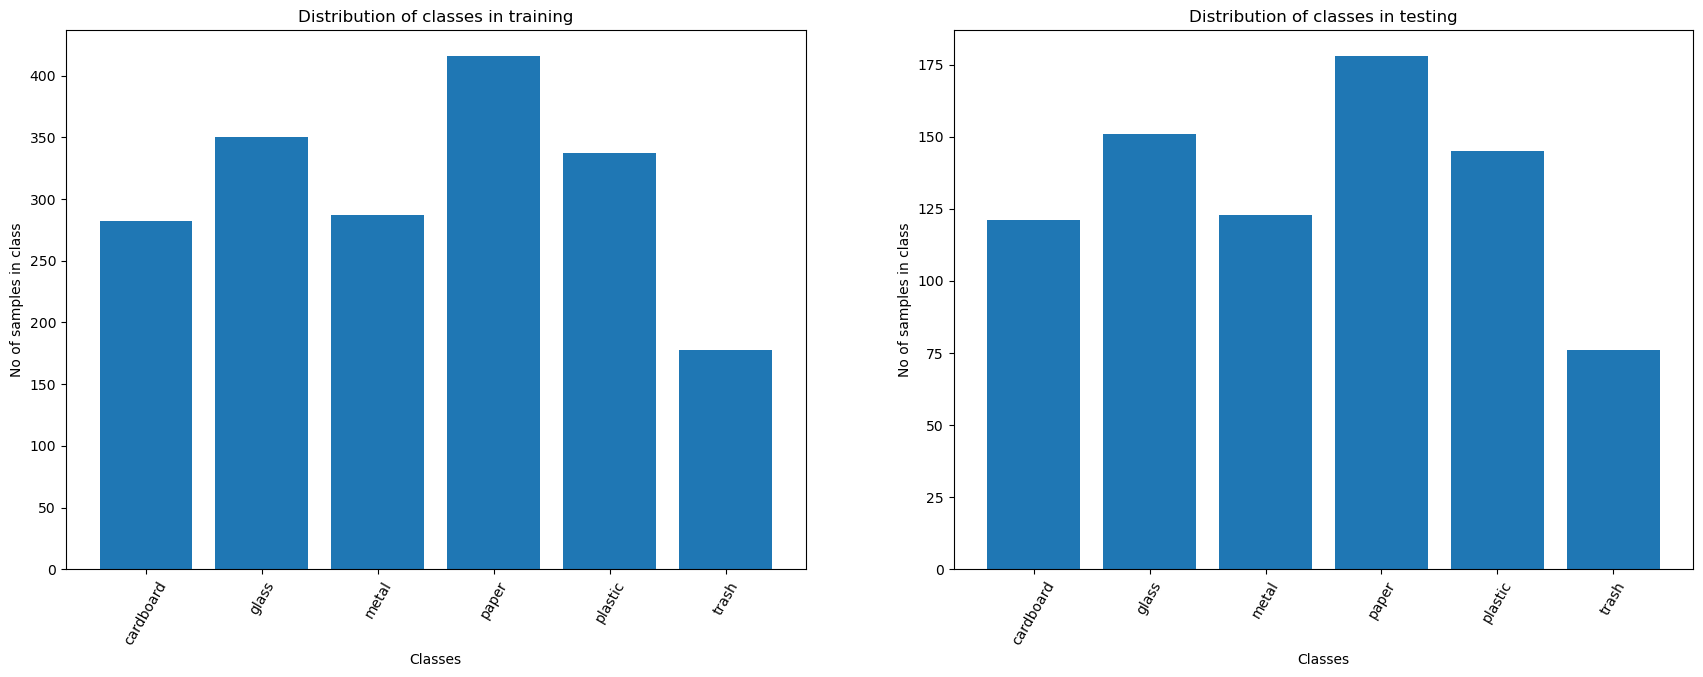

In [29]:
# Plot the distribution of classes in train and test sets
plt.figure(figsize=(21,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())


plt.subplot(1,2,2)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());

### CNN Model Architectures:

#### Custom-CNN Model

Custom CNN model with 6 layers: 3 convolution layers and 3 linear layers. The first two convolution layers have a pooling layer and all 3 convolution layers uses batch normalization for training. ReLU activation function is used in all layers.

- 1<sup>st</sup> layer: uses convolution on 128x128 image with kernel size 11x11 depth 16 with zero padding followed by pooling layer of size 3x3 and stride 2
- 2<sup>nd</sup> layer: input of previous layer with depth 32 annd kernel size 7x7 with zero padding followed by pooling layer of size 3x3 and stride 2  
- 3<sup>rd</sup> layer: input of previous layer with depth 32 annd kernel size 3x3 with zero padding
- 4<sup>th</sup>,5<sup>th</sup>,6<sup>th</sup> layer: dense layer with output 256 -> 128 -> 9


#### ResNet50 Model

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer).

The 50-layer ResNet architecture includes the following elements, as shown in the table below:

- A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.
- A max pooling layer with a 2-sized stride.
- 9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times. 
- 12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.
- 18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.
- 9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.
(up to this point the network has 50 layers)

- Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.


In [21]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16928, 256),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
                nn.Linear(256, 128),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(128, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = resnet50(pretrained=True)
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        self.nn.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, NUM_CLASSES))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.nn(x))

### Methods for Evaluation of Model

In [31]:
@torch.no_grad()
def evaluate_model(model,loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for _, (images, labels) in enumerate(loader):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

def pretty_print_metrics(metrics):
    print('-- TEST SET METRICS --')
    print(f'Accuracy: {metrics[0]:.3f}%\nF-score: {metrics[1]:.3f}\nRecall: {metrics[2]:.3f}\nPrecision: {metrics[3]:.3f}')

def run_testing(model_to_test):
    model =None
    if model_to_test=="CustomCNN":
        model = CustomCNN()
    if model_to_test=="ResNet":
        model = ResNet()
    model.load_state_dict(torch.load(f'models/{model_to_test}-model.pt'),strict=False)
    model_to_test_conf_mat, model_to_test_metrics = evaluate_model(model, test_set_loader)
    pretty_print_metrics(model_to_test_metrics)
    plot_cm(np.array(model_to_test_conf_mat), CLASSES)

### Plotting Utilities

In [32]:
# Utility method to plot the confusion matrix over k-folds
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

# Utility method to plot both accuracy vs num epochs and loss vs num epochs
def plot_training_metrics(training_metrics_df):
    fig, ax = plt.subplots(2, figsize=(20,10))

    ax[0].set_xlabel('Number of epochs')
    ax[1].set_xlabel('Number of epochs')
    ax[0].set_ylabel('Training accuracy %')
    ax[1].set_ylabel('Training loss')
    
    ax[0].set_title('Training Accuracy vs Number of Epochs')
    ax[1].set_title('Training Loss vs Number of Epochs')
    ax[0].plot(training_metrics_df.epoch.values, training_metrics_df.accuracy.values)
    ax[1].plot(training_metrics_df.epoch.values, training_metrics_df.loss.values)

### Method for training model

In [33]:
# the actual training loop given a model, data loader, optimizer
def training_loop(model, train_loader, optimizer, total_step,name):
    epoch_metrics = []

    for epoch in range(NUM_EPOCHS):
        loss_val = 0.0
        acc_val = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = loss.item()
            acc_val = (correct / total) * 100
            
            epoch_metrics.append({'epoch':epoch + (i/total_step),'loss':loss_val, 'accuracy':acc_val})
            
            print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

    torch.save(model.state_dict(), f'models/{name}-model.pt')
    return epoch_metrics

def train(model,save):
    epoch_metrics_df = pd.DataFrame(columns=['epoch','loss','accuracy'])
    model.to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # run training
    epoch_metrics = training_loop(model, train_sampled_dataloader, optimizer, len(train_sampled_dataloader),save)
    epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)
    epoch_metrics_df.to_pickle(f'metric/{save}-metric.pkl')
    return epoch_metrics_df

### Training Data using ResNet50(Pre-Trained) Model

In [34]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
LOSS_FN = nn.CrossEntropyLoss()

#epoch_metrics_df =train(ResNet(),'ResNet')

C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40], Step [1/3], Loss: 1.7941, Accuracy: 13.60
Epoch [1/40], Step [2/3], Loss: 1.7092, Accuracy: 38.00
Epoch [1/40], Step [3/3], Loss: 1.6595, Accuracy: 42.40
Epoch [2/40], Step [1/3], Loss: 1.5866, Accuracy: 54.40
Epoch [2/40], Step [2/3], Loss: 1.5478, Accuracy: 61.40
Epoch [2/40], Step [3/3], Loss: 1.4828, Accuracy: 65.20
Epoch [3/40], Step [1/3], Loss: 1.4507, Accuracy: 65.40
Epoch [3/40], Step [2/3], Loss: 1.4228, Accuracy: 70.00
Epoch [3/40], Step [3/3], Loss: 1.3852, Accuracy: 76.60
Epoch [4/40], Step [1/3], Loss: 1.3950, Accuracy: 71.80
Epoch [4/40], Step [2/3], Loss: 1.3471, Accuracy: 75.40
Epoch [4/40], Step [3/3], Loss: 1.3316, Accuracy: 75.20
Epoch [5/40], Step [1/3], Loss: 1.3376, Accuracy: 74.80
Epoch [5/40], Step [2/3], Loss: 1.3396, Accuracy: 73.00
Epoch [5/40], Step [3/3], Loss: 1.3124, Accuracy: 77.60
Epoch [6/40], Step [1/3], Loss: 1.3077, Accuracy: 77.40
Epoch [6/40], Step [2/3], Loss: 1.3026, Accuracy: 78.00
Epoch [6/40], Step [3/3], Loss: 1.2761, Accuracy

C:\Users\kshit\AppData\Local\Temp\ipykernel_20708\3199988711.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)


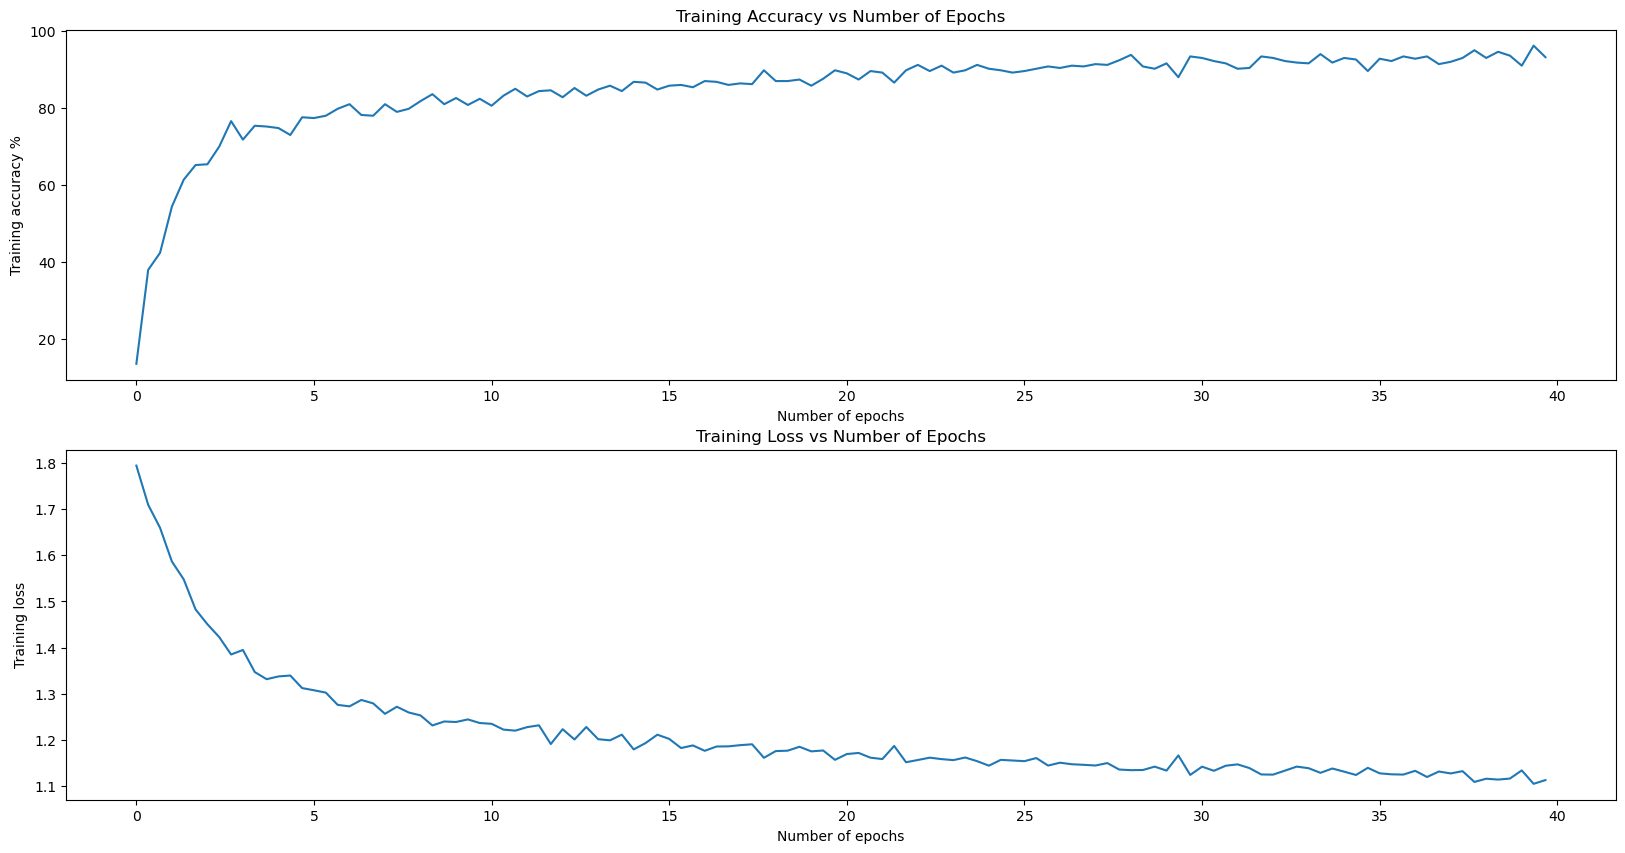

In [35]:
#plot_training_metrics(pd.read_pickle("metric/ResNet-metric.pkl"))

C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-- TEST SET METRICS --
Accuracy: 80.200%
F-score: 0.793
Recall: 0.788
Precision: 0.802
Confusion matrix


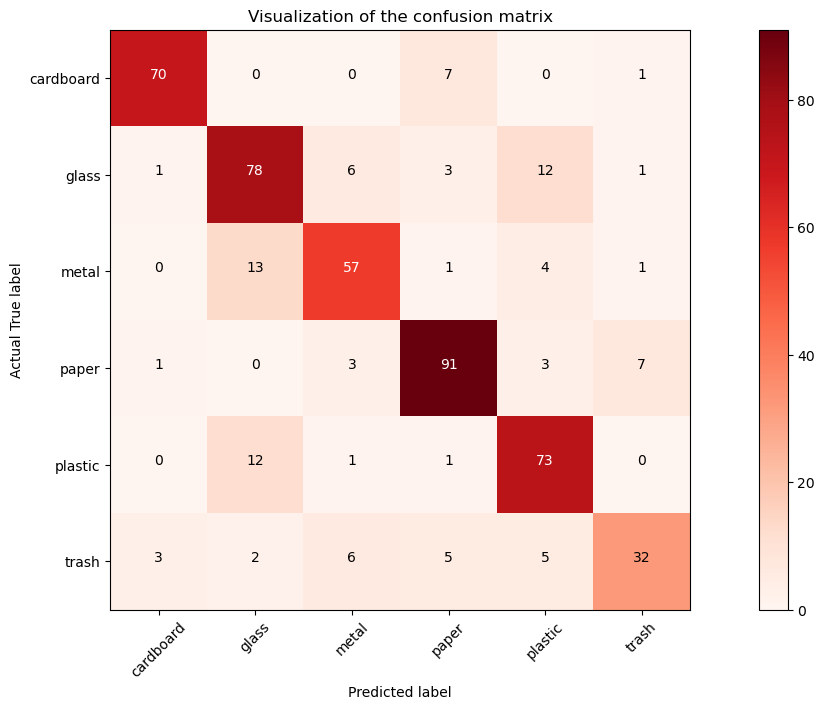

In [36]:
#run_testing('ResNet')

### Training Data using Custom-CNN Model

In [37]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
LOSS_FN = nn.CrossEntropyLoss()

#epoch_metrics_df =train(CustomCNN(),'CustomCNN')

Epoch [1/50], Step [1/3], Loss: 2.2198, Accuracy: 11.40
Epoch [1/50], Step [2/3], Loss: 2.0514, Accuracy: 18.40
Epoch [1/50], Step [3/3], Loss: 2.3848, Accuracy: 27.20
Epoch [2/50], Step [1/3], Loss: 1.9453, Accuracy: 33.20
Epoch [2/50], Step [2/3], Loss: 1.6553, Accuracy: 36.00
Epoch [2/50], Step [3/3], Loss: 1.4897, Accuracy: 41.60
Epoch [3/50], Step [1/3], Loss: 1.5004, Accuracy: 42.20
Epoch [3/50], Step [2/3], Loss: 1.3900, Accuracy: 45.60
Epoch [3/50], Step [3/3], Loss: 1.4336, Accuracy: 47.40
Epoch [4/50], Step [1/3], Loss: 1.3643, Accuracy: 49.00
Epoch [4/50], Step [2/3], Loss: 1.3728, Accuracy: 47.60
Epoch [4/50], Step [3/3], Loss: 1.3325, Accuracy: 49.20
Epoch [5/50], Step [1/3], Loss: 1.2299, Accuracy: 56.60
Epoch [5/50], Step [2/3], Loss: 1.2508, Accuracy: 52.00
Epoch [5/50], Step [3/3], Loss: 1.3121, Accuracy: 50.20
Epoch [6/50], Step [1/3], Loss: 1.2025, Accuracy: 53.40
Epoch [6/50], Step [2/3], Loss: 1.1904, Accuracy: 56.00
Epoch [6/50], Step [3/3], Loss: 1.1662, Accuracy

Epoch [49/50], Step [2/3], Loss: 0.1554, Accuracy: 94.80
Epoch [49/50], Step [3/3], Loss: 0.1527, Accuracy: 95.80
Epoch [50/50], Step [1/3], Loss: 0.1372, Accuracy: 96.20
Epoch [50/50], Step [2/3], Loss: 0.1856, Accuracy: 94.40
Epoch [50/50], Step [3/3], Loss: 0.1911, Accuracy: 92.80


C:\Users\kshit\AppData\Local\Temp\ipykernel_20708\3199988711.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)


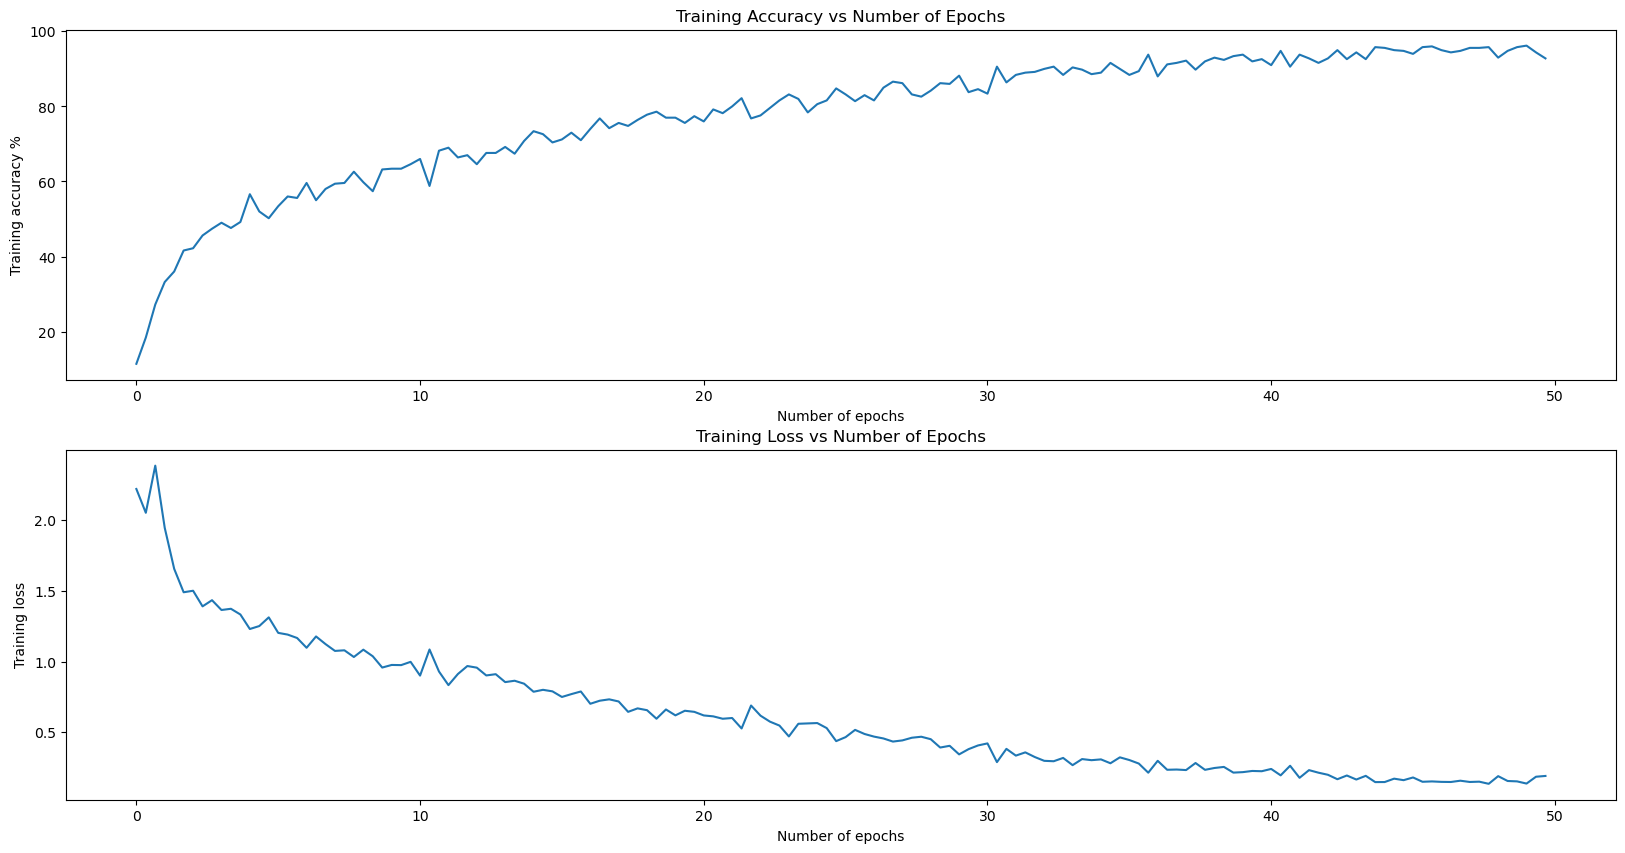

In [38]:
#plot_training_metrics(pd.read_pickle("metric/CustomCNN-metric.pkl"))

-- TEST SET METRICS --
Accuracy: 69.000%
F-score: 0.686
Recall: 0.686
Precision: 0.690
Confusion matrix


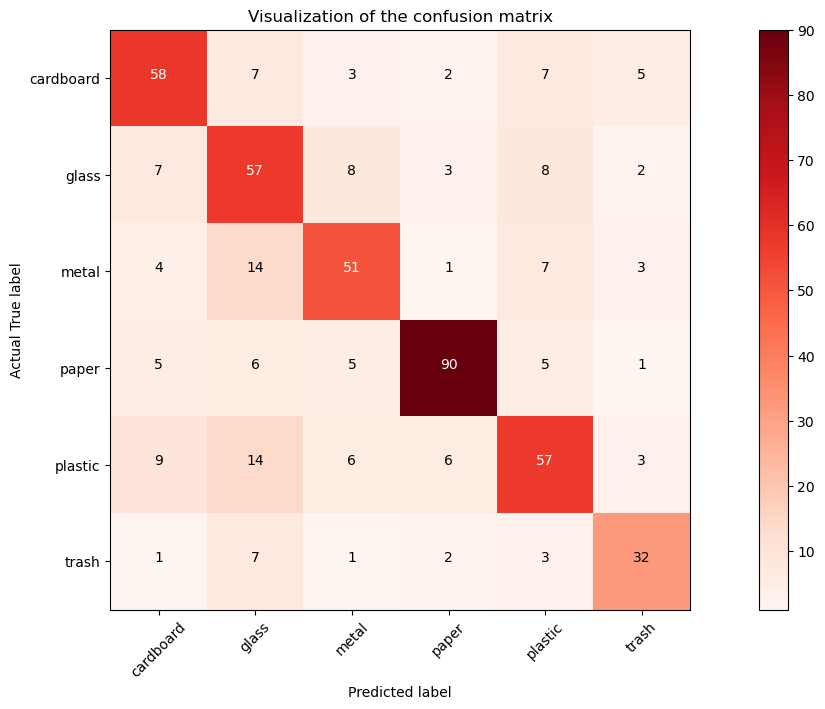

In [39]:
#run_testing('CustomCNN')

### HOG (Histogram of Gradients) with SVM

A class of waste items vary so much shape. Structural cues like shape may give a more robust representation. Gradients of specific directions captures some notion of shape. To allow for some variability in shape, we’ll use features known as Histogram of Oriented Gradients (HOG).

The idea of HOG is instead of using each individual gradient direction of each individual pixel of an image, we group the pixels into small cells. For each cell, we compute all the gradient directions and group them into a number of orientation bins. We sum up the gradient magnitude in each sample. So stronger gradients contribute more weight to their bins, and effects of small random orientations due to noise is reduced. This histogram gives us a picture of the dominant orientation of that cell. Doing this for all cells gives us a representation of the structure of the image. The HOG features keep the representation of an object distinct but also allow for some variations in shape.

### Classifier
We use multiclass support vector machines as our classifier. The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

### Steps for training

- Extract HOG features from training and test images
- Use Multiclass SVM to train model to classify the HOG features
- Test the model using test set

In [9]:
from skimage.feature import hog
import imageio
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score
import _pickle as pickle
from skimage.feature import match_descriptors, plot_matches, SIFT
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

### Method to extract HOG features

In [10]:
def create_features_dataset(train=True,loader=None):
    train_test = "train"
    if(not train):
        train_test="test"

    hog_features=[]
    hog_images=[]
    landmarks=[]
    labels_list=[]
    for i, (images, labels) in enumerate(loader):
        for i in (range(len(labels.numpy()))):
            img = images.numpy()[i,1]
            labels_list.append(labels.numpy()[i])
            features, hog_image = hog(img, orientations=9, pixels_per_cell=(6, 6),
                                      cells_per_block=(3, 3), visualize=True)
            hog_features.append(features)
            hog_images.append(hog_image)
            
    np.save(f'data/hog_features_{train_test}.npy',hog_features)
    np.save(f'data/labels_{train_test}.npy',labels_list)
    np.save(f'data/hog_images_{train_test}.npy',hog_images)
            
    print(f'Hog Features created in data/hog_features{train_test}.npy')
    print(f'Hog Images created in data/hog_images_{train_test}.npy')
    print(f'Labels created in data/labels_{train_test}.npy')

In [14]:
#create_features_dataset(train=True,loader=train_sampled_dataloader)
#create_features_dataset(train=False,loader=test_set_loader)

Hog Features created in data/hog_featurestrain.npy
Hog Images created in data/hog_images_train.npy
Labels created in data/labels_train.npy
Hog Features created in data/hog_featurestest.npy
Hog Images created in data/hog_images_test.npy
Labels created in data/labels_test.npy


### Visualizing HOG Images

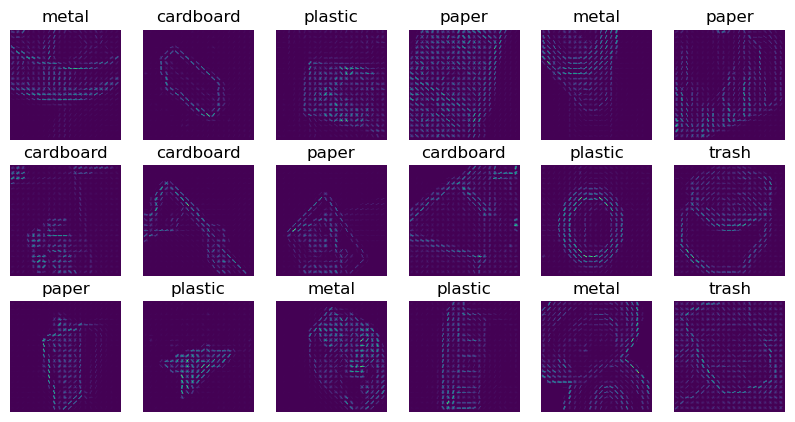

In [8]:
def visualize_hog_images(n_row=10,n_col=10):
    
    dict={0:'cardboard',1:'glass',2:'metal',3:'paper',4:'plastic',5:'trash'}
    
    plt.figure(figsize=(10,5)) 
    hog_img = np.load("data/hog_images_train.npy",allow_pickle=True)
    hog_labels = np.load("data/labels_train.npy",allow_pickle=True)
    for i in range(n_row*n_col):
        plt.subplot(n_row,n_col,i+1)
        plt.title(dict[hog_labels[i]])
        plt.imshow(hog_img[i])
        plt.axis('off')

visualize_hog_images(n_row=3,n_col=6)

### Method to load, train and evaluate data

In [15]:
def load_data(hog_features_f,labels):
    data_dict = dict()
    
    data_dict['X'] = np.load(hog_features_f)
    data_dict['Y'] = np.load(labels)
    
    return data_dict

def evaluate(model, X, Y):
        predicted_Y = model.predict(X)
        accuracy = accuracy_score(Y, predicted_Y)
        return accuracy

def train_SVC(data,epochs,random_state,kernel,decision_function,gamma):
    
    model = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function, gamma=gamma)

    print( "start training...")
    print( "--")
    print( "kernel: {}".format(kernel))
    print( "decision function: {} ".format(decision_function))
    print( "max epochs: {} ".format(epochs))
    print( "gamma: {} ".format(gamma))
    print( "--")
    print( "Training samples: {}".format(len(data['Y'])))
    
    model.fit(data['X'], data['Y'])

    with open("models/svm.bin", 'wb') as f:
        pickle.dump(model, f)


    print( "calculating accuracy...")
    accuracy = evaluate(model, data['X'], data['Y'])
    print( "accuracy = {0:.1f}".format(accuracy*100))
    return accuracy


def run_svm_testing(test):
    
    targets = test['Y']
    
    with open("models/svm.bin", 'rb') as f:
        model = pickle.load(f)
    
    predictions = model.predict(test['X'])
     
    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    
    pretty_print_metrics([accuracy,f1,recall,precision])
    plot_cm(np.array(conf_matrix), CLASSES)

In [17]:
train_dict = load_data("data/hog_features_train.npy","data/labels_train.npy")
test_dict = load_data("data/hog_features_test.npy","data/labels_test.npy")

In [18]:
epochs = 1000
random_state = 0
kernel = 'rbf'
decision_function = 'ovr'
gamma = 0.001

#train_SVC(train_dict,epochs=epochs,random_state=random_state,kernel=kernel,decision_function=decision_function,gamma=gamma)

start training...
--
kernel: rbf
decision function: ovr 
max epochs: 1000 
gamma: 0.001 
--
Training samples: 1500
calculating accuracy...
accuracy = 70.0


0.7

-- TEST SET METRICS --
Accuracy: 56.400%
F-score: 0.535
Recall: 0.526
Precision: 0.618
Confusion matrix


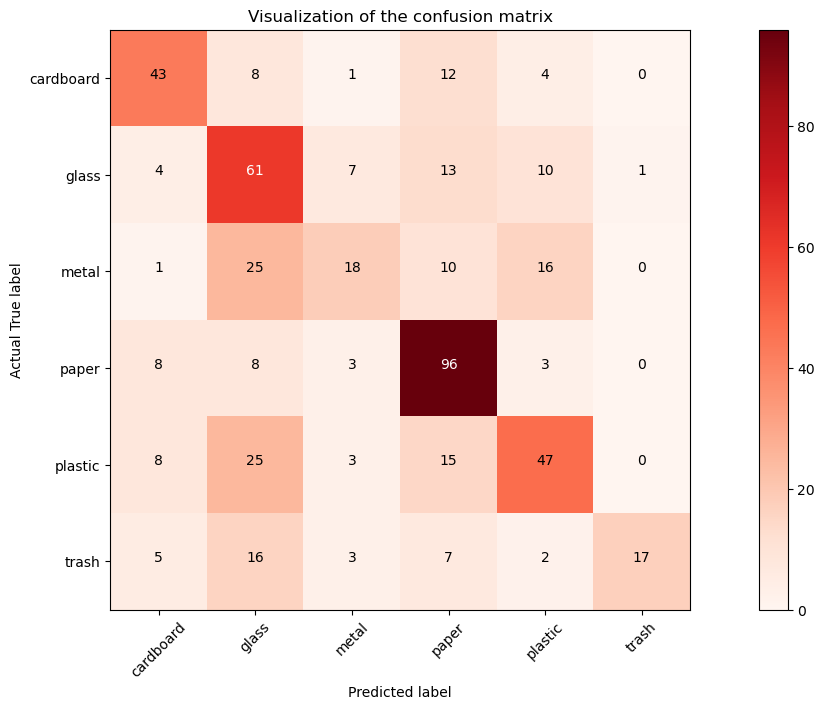

In [23]:
#run_svm_testing(test_dict)

### Predictions with best accuracy model

C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


,actual,predicted
0,paper,paper
1,metal,metal
2,paper,paper
3,plastic,plastic
4,glass,glass
5,paper,trash
6,cardboard,cardboard
7,cardboard,cardboard


<Figure size 1400x700 with 0 Axes>

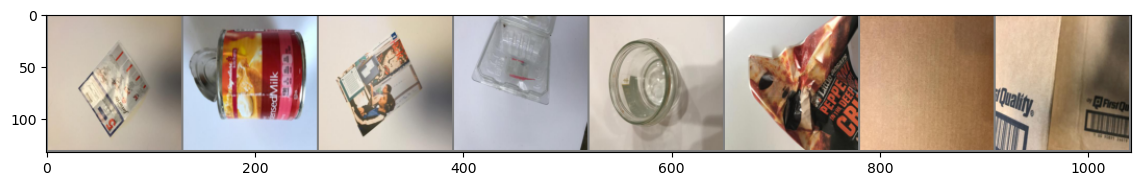

In [41]:
def show_unseen_garbage(garbage_model):
    
    garbage_model_test = ResNet()
    
    garbage_model_test.load_state_dict(torch.load(f'models/{garbage_model}-model.pt'),strict=False)
    unseen_garbage_batch = next(iter(test_set_loader))
    garbage_images, actual_garbage_labels = unseen_garbage_batch
    garbage_model_test.eval()
    imshow(make_grid(garbage_images[:8]))
    garbage_output = garbage_model_test(garbage_images)
    _, predicted_garbage_labels = torch.max(garbage_output.data, 1)
    
    for actual, predicted in zip(actual_garbage_labels,predicted_garbage_labels):
        yield dataset.classes[actual],dataset.classes[predicted]
pd.DataFrame(show_unseen_garbage("ResNet"),columns=['actual','predicted']).head(8)

## Results and Conclusion

We have trained total four models with 3 different approaches:

- Using Pre-trained models
- Using our own CNN architecture
- Using HOG features with SVM

Following are the experimental results given in the table below:

### Experimental Results

| Model/Metric | Accuracy | F-Socre | Recall | Precision |
| --- | --- | --- | --- | --- |
| ResNet50(Pretrained) | 80.200 | 0.793 | 0.788 | 0.802 |
| Custom-CNN |  69.000 | 0.686 | 0.686 | 0.690 |
| SVM with HOG features | 56.4 | 0.535 | 0.526 | 0.618 |

#### Interpreting Results

We can observe that the ResNet50(Pre-trained) model achieves highest accuracy of 80.2% followed by custom-CNN model with 69% and SVM with HOG features with 56.4% accuracy. Similar pattern is observed with other metrics such as F-score, Recall and Precision. The ResNet50(Pre-trained) model results in better results because of its deep convolution residual architecture which is trained on ImageNet dataset containing 1.2 million images natural images and therefore it able to predict general purpose objects. The model is slightly confusing plastic with glass as both are transparent in nature. Similarly vanilla custom-CNN model achieves less accuracy because the model confuses some classes with others like plastic with glass and metal with glass. SVM with HOG features has hard time recognizing metal and class and confuses it with glass and plastic. Also, it confuses plastic with glass. The possible reason for this is that the data in plastic contains plastic bottles and glass has glass bottles therefore the shapes are similar and it is difficult to differentiate between plastic bottles and glass bottles.  From the HOG images we can observe that for plastic, metal, cardboard the images can be same and there is no specific differentiation in structure and shape of objects. Hence the SVM with HOG features model does not perform well.

### Conclusion

Transfer learning approach to image classification has proven to be very effective as compared to other approaches resulting in high accuracy and precision for the problem statement used in this paper. This is most likely due to its very deep architecture and huge training data of natural images. The predictor performance is relatively good with yielding accuracy of almost 80%. To improve turnaround times for prediction, skip connections can be used in architecture. The vanilla custom CNN model while showing reasonable test performance can be improved by using deep CNN architecture and more training data. The performance of the model could be improved by increasing the number of epochs as there are no signs of overfitting. The feature-based model using HOG features with SVM classifier is a good approach in case of limited computing capability however the model has limitations as it tries to classify based on HOG features which consider the structure and shape of the object and in real world many objects from different categories can have similar shape and structure. 

Furthermore, by increasing the resolution of the images it is possible to extract SIFT features which could provide better performance for feature-based models. The almost equal distribution of classes within dataset provides less bias. Therefore, we can conclude that Deep CNN models are better for image classification problems than feature based models.